**@BY 용석님**

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc

## window
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

## mac
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

### 이미지 크롤링을 활용한 학습 이미지 수집

* 수집한 이미지를 저장하기 위한 폴더를 생성하고, 필요한 함수를 정의합니다.

In [5]:
# 필요한 라이브러리 설치하기
!git clone https://github.com/ndb796/bing_image_downloader

fatal: destination path 'bing_image_downloader' already exists and is not an empty directory.


In [2]:
import os
import shutil
from bing_image_downloader.bing_image_downloader import downloader


directory_list = [
    './custom_dataset/train/',
    './custom_dataset/test/',
]

# 초기 디렉토리 만들기
for directory in directory_list:
    if not os.path.isdir(directory):
        os.makedirs(directory)

# 수집한 이미지를 학습 데이터와 평가 데이터로 구분하는 함수
def dataset_split(query, train_cnt):
    # 학습 및 평가 데이터셋 디렉토리 만들기
    for directory in directory_list:
        if not os.path.isdir(directory + '/' + query):
            os.makedirs(directory + '/' + query)
    # 학습 및 평가 데이터셋 준비하기
    cnt = 0
    for file_name in os.listdir(query):
        if cnt < train_cnt:
            print(f'[Train Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/train/' + query + '/' + file_name)
        else:
            print(f'[Test Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/test/' + query + '/' + file_name)
        cnt += 1
    shutil.rmtree(query)

* <b>맥주</b> 이미지 크롤링을 진행하고 데이터셋을 구축합니다.

In [3]:
beerlist=['Kozel dark beer', 'heineken dark beer', 'pilsner urquell beer', 'tiger lemon beer', 'weihenstephan beer']
for beer in beerlist:
    query = beer
    downloader.download(query, limit=100,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
    dataset_split(query, 70)

<br>

### PyTorch를 이용한 전이 학습(Transfer Learning)</b>

* 전이 학습(transfer learning)

<br>

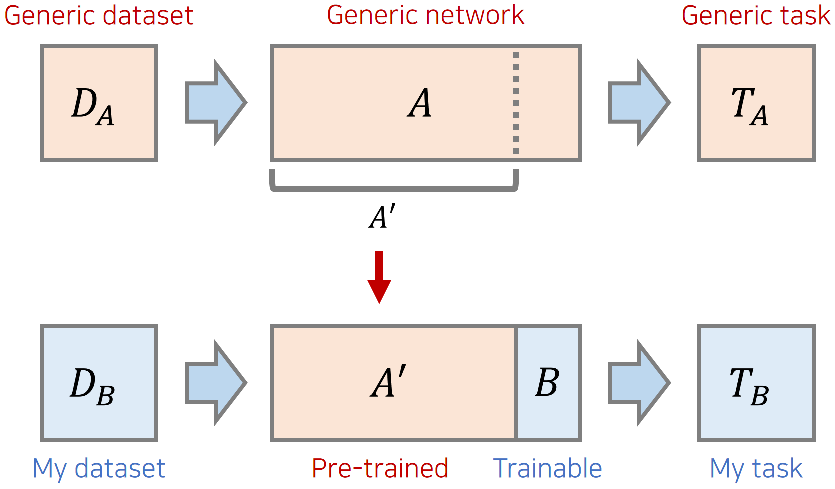

* 학습을 위해 필요한 라이브러리를 불러옵니다.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

* 데이터셋을 불러옵니다.

In [4]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 247
테스트 데이터셋 크기: 75
클래스: ['Kozel dark beer', 'heineken dark beer', 'pilsner urquell beer', 'tiger lemon beer', 'weihenstephan beer']


* 간단히 이미지를 시각화해 봅시다.

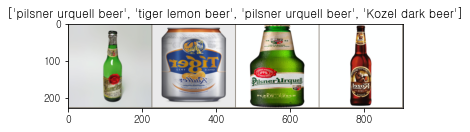

In [5]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

* 학습할 CNN 딥러닝 모델 객체를 초기화합니다.

In [6]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 5개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 5)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

* 학습을 진행합니다.

In [7]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

D:\Programing\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


#0 Loss: 1.1460 Acc: 55.0607% Time: 62.4576s
#1 Loss: 0.4020 Acc: 86.6397% Time: 124.2399s
#2 Loss: 0.2807 Acc: 91.4980% Time: 186.0907s
#3 Loss: 0.1652 Acc: 94.7368% Time: 248.9952s
#4 Loss: 0.3061 Acc: 88.6640% Time: 311.2369s
#5 Loss: 0.2328 Acc: 91.4980% Time: 373.1820s
#6 Loss: 0.3111 Acc: 88.6640% Time: 435.2642s
#7 Loss: 0.2183 Acc: 92.3077% Time: 496.8196s
#8 Loss: 0.2259 Acc: 91.9028% Time: 560.0675s
#9 Loss: 0.3070 Acc: 89.4737% Time: 624.4860s
#10 Loss: 0.1676 Acc: 94.3320% Time: 688.5409s
#11 Loss: 0.0824 Acc: 96.7611% Time: 751.7893s
#12 Loss: 0.1524 Acc: 96.3563% Time: 814.8040s
#13 Loss: 0.0958 Acc: 97.1660% Time: 876.8383s
#14 Loss: 0.1448 Acc: 95.9514% Time: 938.2377s
#15 Loss: 0.0557 Acc: 98.7854% Time: 999.6386s
#16 Loss: 0.1736 Acc: 96.3563% Time: 1061.0457s
#17 Loss: 0.1139 Acc: 96.3563% Time: 1121.9924s
#18 Loss: 0.0466 Acc: 99.1903% Time: 1182.7090s
#19 Loss: 0.0539 Acc: 97.5708% Time: 1243.8468s
#20 Loss: 0.1069 Acc: 96.7611% Time: 1305.3616s
#21 Loss: 0.0374 Ac

* 학습된 모델을 평가합니다.

[예측 결과: heineken dark beer] (실제 정답: heineken dark beer)


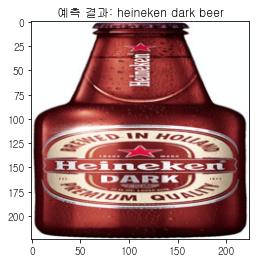

[예측 결과: pilsner urquell beer] (실제 정답: pilsner urquell beer)


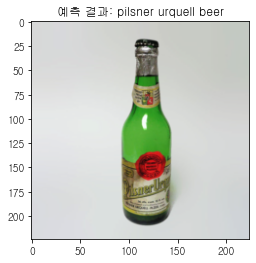

[예측 결과: tiger lemon beer] (실제 정답: tiger lemon beer)


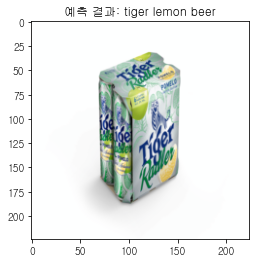

[예측 결과: pilsner urquell beer] (실제 정답: pilsner urquell beer)


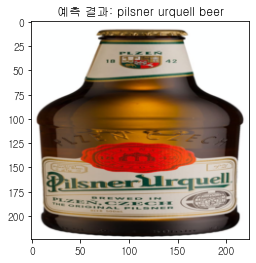

[예측 결과: Kozel dark beer] (실제 정답: Kozel dark beer)


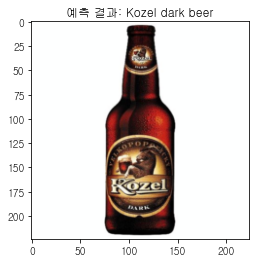

[예측 결과: heineken dark beer] (실제 정답: heineken dark beer)


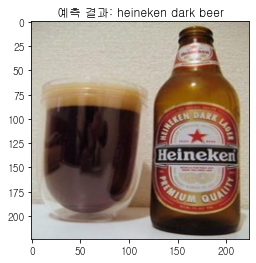

[예측 결과: pilsner urquell beer] (실제 정답: pilsner urquell beer)


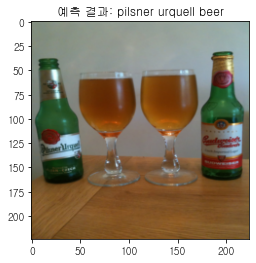

[예측 결과: tiger lemon beer] (실제 정답: tiger lemon beer)


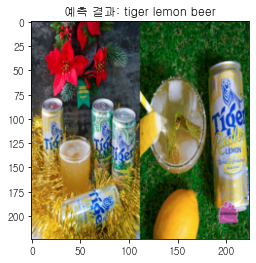

[예측 결과: Kozel dark beer] (실제 정답: Kozel dark beer)


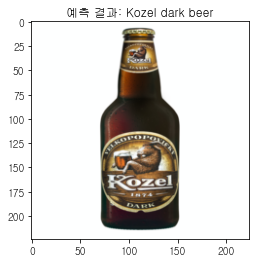

[예측 결과: weihenstephan beer] (실제 정답: weihenstephan beer)


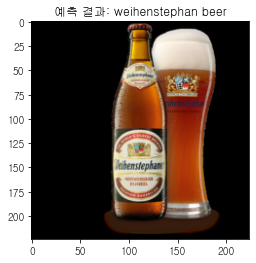

[예측 결과: tiger lemon beer] (실제 정답: tiger lemon beer)


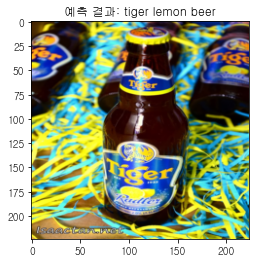

[예측 결과: heineken dark beer] (실제 정답: heineken dark beer)


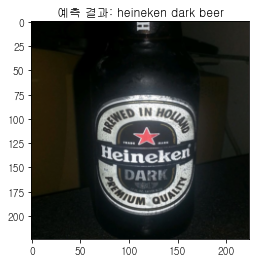

[예측 결과: pilsner urquell beer] (실제 정답: pilsner urquell beer)


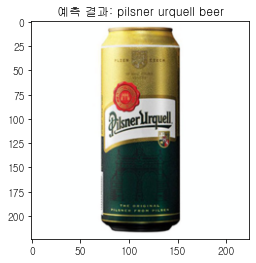

[예측 결과: weihenstephan beer] (실제 정답: weihenstephan beer)


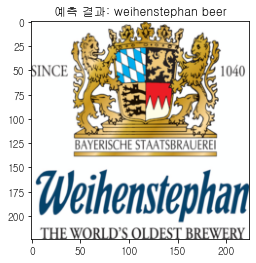

[예측 결과: heineken dark beer] (실제 정답: heineken dark beer)


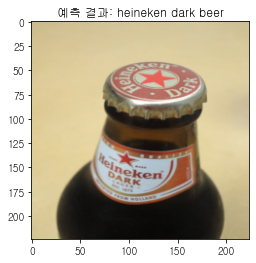

[예측 결과: Kozel dark beer] (실제 정답: Kozel dark beer)


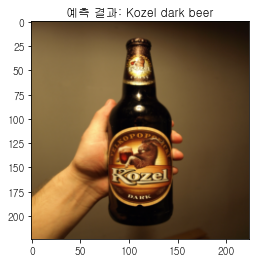

[예측 결과: heineken dark beer] (실제 정답: heineken dark beer)


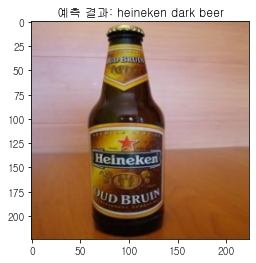

[예측 결과: tiger lemon beer] (실제 정답: tiger lemon beer)


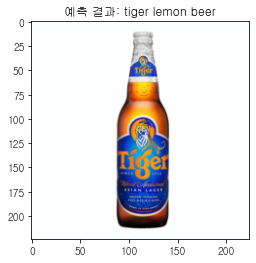

[예측 결과: tiger lemon beer] (실제 정답: tiger lemon beer)


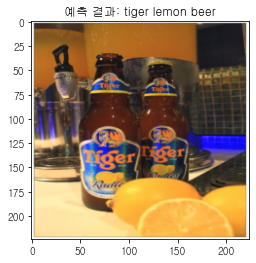

[Test Phase] Loss: 0.1518 Acc: 94.6667% Time: 11.6019s


In [8]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

In [9]:
# 모델 저장
torch.save(model.state_dict(),'./cnn.pth')

In [11]:
cnn_model =  models.resnet34(pretrained=True)
num_features2 = cnn_model.fc.in_features
cnn_model.fc = nn.Linear(num_features, 5)
cnn_model.load_state_dict(torch.load('./cnn.pth'))

<All keys matched successfully>

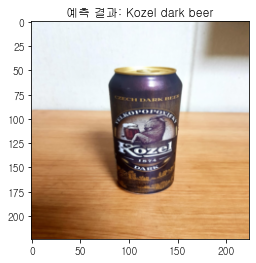

In [12]:
from PIL import Image

image = Image.open('./test_image.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

<br>

### 분류 모델 API 개발

* 학습된 분류 모델을 다른 사람이 사용할 수 있도록 API를 개발하여 배포합니다.
* 먼저 한 장의 이미지를 파일로부터 읽어와 분류 결과를 반환하는 기능을 작성합니다.

In [ ]:
from PIL import Image

image = Image.open('test_image.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

* 웹 API 개방을 위해 <b>Ngrok</b> 서비스를 이용합니다.
* API 기능 제공을 위해 <b>Flask 프레임워크</b>를 사용합니다.

In [ ]:
# 필요한 라이브러리 설치하기
!pip install flask-ngrok

In [ ]:
import io
from flask_ngrok import run_with_ngrok
from flask import Flask, jsonify, request


# 이미지를 읽어 결과를 반환하는 함수
def get_prediction(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    image = transforms_test(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    return class_names[preds[0]]


app = Flask(__name__)


@app.route('/', methods=['POST'])
def predict():
    if request.method == 'POST':
        # 이미지 바이트 데이터 받아오기
        file = request.files['file']
        image_bytes = file.read()

        # 분류 결과 확인 및 클라이언트에게 결과 반환
        class_name = get_prediction(image_bytes=image_bytes)
        print("결과:", {'class_name': class_name})
        return jsonify({'class_name': class_name})

* API를 개방할 수 있으며 실행할 때마다 서버의 주소가 변경됩니다.
* 서버 주소를 정확히 확인할 필요가 있습니다.

In [ ]:
run_with_ngrok(app)
app.run()

* 클라이언트 테스트 방법

<pre>
curl -X POST -F file=@{이미지 파일명} {Ngrok 서버 주소}
</pre>

* 사용 예시

<pre>
curl -X POST -F file=@dongseok.jpg http://c4cdb8de3a35.ngrok.io/
</pre>

* 이러한 방식으로 웹, 모바일, 게임 등의 소프트웨어 환경에서 API를 호출하는 방식으로 인공지능 앱을 개발할 수 있습니다.